# MODEL 2

This notebook shows the implementation of the model 2. See the documenation for further details.

#### The preprocessing we apply is the simple one; 
#### We consider the dataset union of violations,train and test20 samples;
#### The Doc2vec model is trained on all the possible samples;
#### The SVM is trained by applying a 10-fold cross-validation which means we trained the SMV on  9-folds of the dataset (train+test20 of the i-th article) and tested on the remaining 1-fold. and tested on the remaining 1-fold  (seperately for each article).

In [1]:
import os
import sys
import shutil
import random
import re
import regex
import string
from random import shuffle
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import KFold
from gensim import models
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn import svm, metrics
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
from sklearn.preprocessing import normalize
from module_preprocessing import apply_preprocessing,merge_dataset
from ast import literal_eval

random_seed = [1234, 232345, 334456, 454567, 567448, 67839, 9822276, 763454, 644543, 3454421]

For this experiments we consider the article 3: 

In [4]:
d1 = pd.read_csv(
    "crystal_ball_data/SIMPLE_PREP/test_RAW_DATASET/Article03.csv",
    index_col='index')
d1.raw_text = d1.raw_text.apply(literal_eval)
dataframe=pd.read_csv(
    "crystal_ball_data/SIMPLE_PREP/train_RAW_DATASET/Article03.csv",
    index_col='index')
dataframe.raw_text = dataframe.raw_text.apply(literal_eval)
dataframe = dataframe.append(d1)

In [5]:
dataframe.shape

(706, 2)

In [ ]:
d2 = pd.read_csv(
    "crystal_ball_data/SIMPLE_PREP/all_train_simple_rd.csv",
    index_col='index')
d2.raw_text = d2.raw_text.apply(literal_eval)
d3 = pd.read_csv(
    "crystal_ball_data/SIMPLE_PREP/all_violations_simple_rd.csv",
    index_col='index')
d3.raw_text = d3.raw_text.apply(literal_eval)

In [7]:
data_all = pd.read_csv(
    "crystal_ball_data/SIMPLE_PREP/all_test20_simple_rd.csv",
    index_col='index')
data_all.raw_text = data_all.raw_text.apply(literal_eval)
data_all = data_all.append(d2)
data_all = data_all.append(d3)
data_all.shape

(12268, 2)

In [8]:
vector_size = 100
documents = []
for index, sample in data_all.iterrows():
    documents.append(
        TaggedDocument(words=sample['raw_text'], tags=[sample['tag']]))

model_D2V = Doc2Vec(
    documents,
    vector_size=vector_size,
    epochs=20,
    min_count=1,
    workers=os.cpu_count())
#model_D2V.save("model_D2V/sh"+str(count)+"_cv"+str(i))

In [9]:
def create_vector_dataset(df, model,df_vector=pd.DataFrame()):
    '''
     This function creates a well structured dataset, which consists of n columns: n features and the tag.
     It transforms strings to vectors through the model Doc2Vec.
     which consists of n columns: n features and the tag. 
      Args:
         df (DataFrame): an semi-structured dataframe, look at create_raw_dataset.  
         model (Doc2Vec) : a trained Doc2Vec model.
         df_vector (DataFrame): an initialized dataframe with shape (n_features+1,).
      Returns :
         (DataFrame) a Dataframe with shape (n_features+1,n_samples). 
    '''
    
    for index, sample in df.iterrows():
        vector = model.infer_vector(doc_words=sample['raw_text'], steps=20)
        dic = {}
        for i in range(len(vector)):
            dic['y_' + str(i)] = vector[i]
        dic['tag'] = sample['tag']
        df_vector = df_vector.append(dic, ignore_index=True)
    df_vector.loc[:, 'y_0':'y_' + str(len(vector) - 1)] = normalize(
            df_vector.loc[:, 'y_0':'y_' + str(len(vector) - 1)],
            norm='l2',
            axis=0)
    return df_vector

In [10]:
def main(df,
         n_shuffles=10,
         n_splits=10,
         vector_size=100,
         verbose=0):

    matr_accuracy = np.zeros((n_shuffles, n_splits), dtype=float)
    if verbose >= 0:
        print("SEEDs: ", random_seed)

    for i in range(n_shuffles):

        if verbose >= 1:
            print("\n\n_______Shuffle number " + str(i) + "_______\nSEED:" +
                  str(random_seed[i]))
        random.seed(random_seed[i])
        df = df.sample(
            frac=1, random_state=random_seed[i]).reset_index(drop=True)
        if verbose >= 2:
            print("SHUFFLED DATASET: \n")
            print(df.head(3))
            print(df.shape)
        kf = KFold(n_splits=n_splits)
        count = 0
        for train_index, test_index in kf.split(df):
            if verbose >= 1:
                print("_______cross validation round: " + str(count) +
                      "_______")
            if verbose >= 3: print("test indexes: ", test_index)
    
            df_test = df.loc[test_index[0]:test_index[len(test_index) - 1]]
            df_train = df.drop(df.index[test_index])
            if verbose >= 3:
                print("TEST SET: ", df_test)
                print("shape: ", df_test.shape)
                print("TRAIN SET:", df_train.head(10))
                print("shape: ", df_train.shape)
            
            df_vector = create_vector_dataset(df_train, model_D2V)
            df_test_vector = create_vector_dataset(df_test, model_D2V)
            if verbose >= 2:
                print("TEST SET VECTOR: ", df_test_vector.head(10))
                print("shape: ", df_test_vector.shape)
                print("TRAIN SET:", df_vector.head(10))
                print("shape: ", df_vector.shape)


            clf_svm = svm.SVC(kernel='linear',C=1)
            clf_svm.fit(
                df_vector.loc[:, 'y_0':'y_' + str(vector_size - 1)].values,
                df_vector.loc[:, 'tag'].values)

            predictions = clf_svm.predict(
                df_test_vector.loc[:, 'y_0':'y_' +
                                   str(vector_size - 1)].values)
            tag_test = df_test_vector.loc[:, 'tag'].values
            acc = metrics.accuracy_score(tag_test, predictions)
            if verbose >= 0:
                print("ACCURACY:", acc)
                #print("Precision:",metrics.precision_score(tag_test, predictions))
                #print("Recall:",metrics.recall_score(tag_test, predictions))

            matr_accuracy[i][count] = acc
            count += 1

    return matr_accuracy

Note: 
* Be sure you are in the same folder contaning the Crystal Ball data set.
* You might need to install some libraries, here's the list: 
{'string', 'nltk', 'json', 'regex', 'os', 're', 'sys', 'shutil', 'random'}
SEEDs:  [1234, 232345, 334456, 454567, 567448, 67839, 9822276, 763454, 644543, 3454421]


_______Shuffle number 0_______
SEED:1234
_______cross validation round: 0_______
ACCURACY: 0.7183098591549296
_______cross validation round: 1_______
ACCURACY: 0.6338028169014085
_______cross validation round: 2_______
ACCURACY: 0.7323943661971831
_______cross validation round: 3_______
ACCURACY: 0.704225352112676
_______cross validation round: 4_______
ACCURACY: 0.8028169014084507
_______cross validation round: 5_______
ACCURACY: 0.8309859154929577
_______cross validation round: 6_______
ACCURACY: 0.8428571428571429
_______cross validation round: 7_______
ACCURACY: 0.7428571428571429
_______cross validation round: 8_______
ACCURACY: 0.7714285714285715
_______cross validation round: 

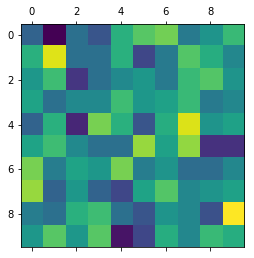

In [11]:
if __name__ == "__main__":
    print(
        "Note: \n* Be sure you are in the same folder contaning the Crystal Ball data set.\n* You might need to install some libraries, here's the list: "
    )
    print(set(sys.modules) & set(globals()))
    %time matr = main(dataframe,n_shuffles=10,n_splits=10,vector_size=vector_size,verbose=1)
    print(matr.__str__())
    plt.matshow(matr)
    plt.show()

mean:  0.7705935613682092
min:  0.6338028169014085
max:  0.9


array([0.75939638, 0.77764588, 0.76923541, 0.77338028, 0.77780684,
       0.76758551, 0.77321932, 0.76921529, 0.76637827, 0.77207243])

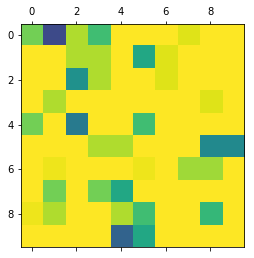

In [12]:
plt.matshow(matr, vmin=0.6, vmax=0.75)

print("mean: ", matr.mean())
print("min: ", matr.min())
print("max: ", matr.max())
matr.mean(1)